In [76]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
df = pd.read_csv("data/weather_daily_2023.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df.head()

,DATE,STATION,TMAX,TMIN,TMAX_F,TMIN_F
0,2023-01-01,USR0000CBAR,150.0,61.0,59.0,43.0
1,2023-01-02,USR0000CBAR,78.0,50.0,46.0,41.0
2,2023-01-03,USR0000CBAR,94.0,50.0,49.0,41.0
3,2023-01-04,USR0000CBAR,128.0,61.0,55.0,43.0
4,2023-01-05,USR0000CBAR,117.0,83.0,53.0,47.0


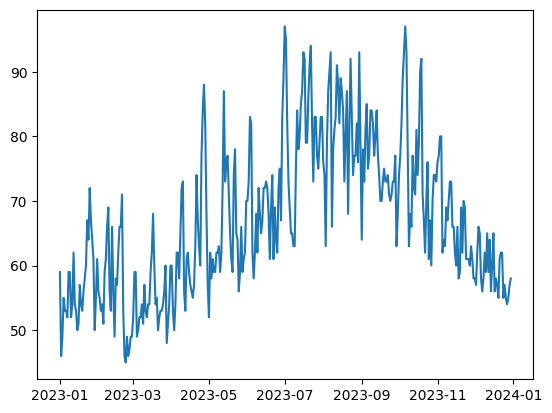

In [78]:
fig, ax = plt.subplots()
ax.plot(df["DATE"], df["TMAX_F"])

In [ ]:
fig, ax = plt.subplots()
ax.plot

In [79]:
def create_sequences(data: pd.DataFrame, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data["TMAX_F"][i:i+seq_length]
        y = data["TMAX_F"][i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30
X, y = create_sequences(df, SEQ_LENGTH)

In [80]:
mean = X.mean()
std = X.std()

X_norm = (X - mean) / std

y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

In [81]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) 
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X_norm, y_norm)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [94]:
df_test = pd.read_csv("data/weather_daily_2024.csv")
df_test["DATE"] = pd.to_datetime(df_test["DATE"])


X_test, y_test = create_sequences(df_test, SEQ_LENGTH)

X_test_norm = (X_test - mean) / std
y_test_norm = (y_test - y_mean) / y_std

dataset_test = TimeSeriesDataset(X_test_norm, y_test_norm)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

In [103]:
# *benchmark* just returns last val in sequence
class NaiveModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # print(x.shape)
        # print(x)
        # return
        out = x[:, -1]
        return out
    
naive_model = NaiveModel()

In [105]:
naive_predictions = naive_model(X_test)
naive_predictions.shape
type(naive_predictions)

numpy.ndarray

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

origin, start_date, end_date = "2024-01-01", "2024-03-01", "2024-05-31"
time_period = pd.date_range(start_date, end_date)
df_test = df_test.set_index("DATE", drop=False).sort_index()
series = df_test.loc[origin:end_date]["TMAX_F"].asfreq("D")


y_preds = []
for today in time_period.shift(-1):
    print(today)
    y_preds.append(1)
    if len(y_preds)==5:
        break
    model = ARIMA(series[origin:today],
                  order=(2, 0, 2),
                  seasonal_order=(1, 0, 1, 365))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mse = ((y_preds - series[time_period]) ** 2).mean()

2024-02-29 00:00:00
2024-03-01 00:00:00
2024-03-02 00:00:00
2024-03-03 00:00:00
2024-03-04 00:00:00


58.479166666666664


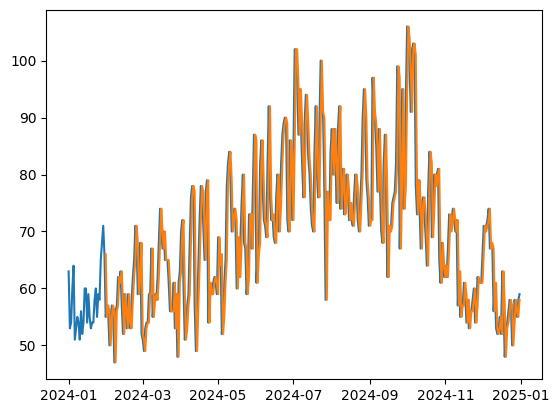

In [107]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df_test[SEQ_LENGTH:]["TMAX_F"], naive_predictions))

fig, ax = plt.subplots()
ax.plot(df_test["DATE"], df_test["TMAX_F"])
ax.plot(df_test[SEQ_LENGTH:]["DATE"], naive_predictions)


In [82]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  
        out = out[:, -1, :]   
        return self.linear(out)

model = LSTMModel()

In [83]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    for x_batch, y_batch in dataloader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.5721
Epoch 1, Loss: 1.1920
Epoch 2, Loss: 0.9981
Epoch 3, Loss: 0.6926
Epoch 4, Loss: 0.4172
Epoch 5, Loss: 0.4587
Epoch 6, Loss: 0.4057
Epoch 7, Loss: 0.3181
Epoch 8, Loss: 0.3951
Epoch 9, Loss: 0.4476
Epoch 10, Loss: 0.5080
Epoch 11, Loss: 0.3960
Epoch 12, Loss: 0.4070
Epoch 13, Loss: 0.3613
Epoch 14, Loss: 0.7808
Epoch 15, Loss: 0.3730
Epoch 16, Loss: 0.4454
Epoch 17, Loss: 0.1717
Epoch 18, Loss: 0.2723
Epoch 19, Loss: 0.4455
Epoch 20, Loss: 0.4870
Epoch 21, Loss: 0.3639
Epoch 22, Loss: 0.2518
Epoch 23, Loss: 0.1388
Epoch 24, Loss: 0.2848
Epoch 25, Loss: 0.5115
Epoch 26, Loss: 0.6442
Epoch 27, Loss: 0.1694
Epoch 28, Loss: 0.4909
Epoch 29, Loss: 0.3501
Epoch 30, Loss: 0.5009
Epoch 31, Loss: 0.2820
Epoch 32, Loss: 0.2561
Epoch 33, Loss: 0.2319
Epoch 34, Loss: 0.4244
Epoch 35, Loss: 0.1339
Epoch 36, Loss: 0.3836
Epoch 37, Loss: 0.1751
Epoch 38, Loss: 0.2968
Epoch 39, Loss: 0.2651
Epoch 40, Loss: 0.3818
Epoch 41, Loss: 0.3596
Epoch 42, Loss: 0.2756
Epoch 43, Loss: 0.121

In [85]:
test_predictions = np.empty((0, 1))
with torch.no_grad():
    for x_batch, y_batch in dataloader_test:
        predictions = model(x_batch)
        predictions_np = predictions.view(-1).numpy()

        test_predictions = np.append(test_predictions, predictions_np)
        

In [86]:
print(test_predictions.shape)

(336,)


In [87]:
df_test[12:]["DATE"].shape

(354,)

In [88]:
test_predictions = test_predictions * y_std + y_mean

263.96600865082246


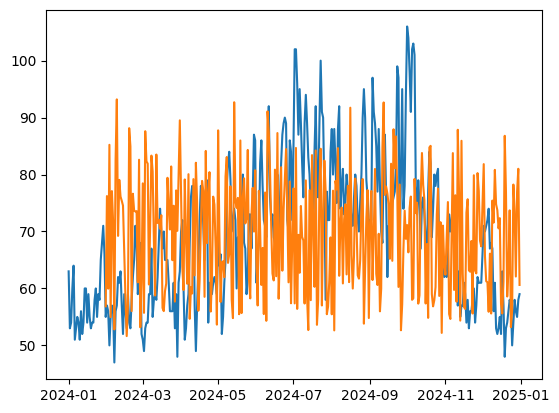

In [108]:
print(mean_squared_error(df_test[SEQ_LENGTH:]["TMAX_F"], test_predictions))

fig, ax = plt.subplots()

ax.plot(df_test["DATE"], df_test["TMAX_F"])
ax.plot(df_test[SEQ_LENGTH:]["DATE"], test_predictions)